In [1]:
# !pip install pydicom

In [2]:
# !pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D

In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from pathlib import Path
from efficientnet_pytorch_3d import EfficientNet3D

from tqdm.notebook import tqdm

from functools import cmp_to_key

In [2]:
class Config():
    epochs = 15
    batch_size = 8
    base_path = Path('/home/RSNA_MICCAI_Brain_Tumor/data')
    assert base_path.exists()
    models_path = Path('/home/RSNA_MICCAI_Brain_Tumor/models')
    assert models_path.exists()
    seed = 42
    num_workers = 7
    model_name = 'efficientnet3d-0'
    
cfg = Config()

In [3]:
if os.path.exists(cfg.base_path):
    data_directory = cfg.base_path
else:
    assert False, "data_directory does not exist"
    
# mri_types = ['FLAIR']
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256
NUM_IMAGES = 64

### Functions to load images

In [4]:
def load_dicom_image(path, img_size=SIZE):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if np.min(data)==np.max(data):
        data = np.zeros((img_size,img_size))
        return data
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    
    #data = (data * 255).astype(np.uint8)
    data = cv2.resize(data, (img_size, img_size))
    return data

def convert_path_to_int(x):
    res = int(re.sub(r'.+\-+(\d+)\..+', r'\1', x))
    return res

def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train"):

    glob_expr = f'{cfg.base_path}/{split}/{scan_id}/{mri_type}/*.dcm'
    files = glob.glob(glob_expr)
    files.sort(key=cmp_to_key(lambda x, y: -1 if convert_path_to_int(x) < convert_path_to_int(y) else 1))
    
    
    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
            
    return np.expand_dims(img3d,0)

load_dicom_images_3d("00000").shape

(1, 256, 256, 64)

In [5]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(cfg.seed)

### train / test splits

In [6]:
train_df = pd.read_csv(f"{data_directory}/train_labels.csv")
display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df["MGMT_value"],
)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [7]:
df_train.tail()

,BraTS21ID,MGMT_value
549,803,0
504,735,0
2,3,0
550,804,0
247,359,1


### Model and training classes

In [8]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
        else:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train")

        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}


In [9]:
torch.clamp(torch.randn([10]), min=0.0)

tensor([0.3367, 0.1288, 0.2345, 0.2303, 0.0000, 0.0000, 2.2082, 0.0000, 0.4617,
        0.2674])

In [11]:
# sample_model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)

In [10]:
class ModelHead(nn.Module):
    
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self._fc = nn.Linear(in_features=in_features, out_features=hidden_dim, bias=True)
        self._fc_2 = nn.Linear(in_features=hidden_dim, out_features=1, bias=True)
        
    def forward(self, x):
        x = self._fc(x)
        x = self._fc_2(x)
        return x

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
        n_features = self.net._fc.in_features
        self.net._fc = ModelHead(n_features, 600)
        
    
    def forward(self, x):
        out = self.net(x)
        return out
    

In [13]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):  
        tbar = tqdm(range(1, epochs + 1), total=epochs)
        self.lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=int(len(train_loader)), T_mult=1, eta_min=0.0001, last_epoch=-1)
        self.lrs = []
        
        for n_epoch in tbar:
            
            self.info_message("EPOCH: {}", n_epoch)
            tbar.set_description(f'EPOCH: {n_epoch}')
            
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            # if True:
            # if self.best_valid_score < valid_auc: 
            if self.best_valid_score > valid_loss and n_epoch > 4 and valid_auc > 0.5: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_loss, self.lastmodel
                )
                self.best_valid_score = valid_loss
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
        plt.plot(self.lrs)
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        tbar = tqdm(enumerate(train_loader, 1), total=len(train_loader))
        
        for step, batch in tbar:
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            sum_loss += loss.detach().item()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.lr_sched.step()
            current_lr = self.optimizer.param_groups[0]["lr"]
            self.lrs.append(
                current_lr
            )
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        tbar = tqdm(enumerate(valid_loader, 1), total=len(valid_loader))
        for step, batch in tbar:
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                outputs = torch.sigmoid(outputs)
                loss = self.criterion(outputs, targets)
                print('outputs', outputs.mean(), outputs.std())
                print('targets', targets.mean(), targets.std())
                
                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(outputs.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = str(cfg.models_path/f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth")
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
    )

    model = Model()
    model.to(device)

    #checkpoint = torch.load("best-model-all-auc0.555.pth")
    #model.load_state_dict(checkpoint["model_state_dict"])

    #print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        cfg.epochs, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        cfg.epochs,
    )
    
    return trainer.lastmodel

In [15]:
!rm -rf {str(cfg.models_path)}/*.pth

(468, 3) (117, 3)


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
102,154,0,FLAIR
161,240,1,FLAIR
508,740,1,FLAIR
495,725,1,FLAIR
298,432,0,FLAIR


EPOCH: 1


Train Step 59/59, train_loss: 0.8708


outputs tensor(0.5070, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5070, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5070, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5070, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5070, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5070, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5070, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.507

Train Step 59/59, train_loss: 0.7222


outputs tensor(0.5094, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5094, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5094, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5094, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5094, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5094, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5094, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.509

Train Step 59/59, train_loss: 0.7165


outputs tensor(0.4998, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4998, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4998, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4998, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4998, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4998, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.4998, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.499

Train Step 59/59, train_loss: 0.7137


outputs tensor(0.5396, device='cuda:0') tensor(4.2147e-08, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5396, device='cuda:0') tensor(3.9020e-08, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5396, device='cuda:0') tensor(7.9650e-08, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5396, device='cuda:0') tensor(8.1227e-08, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5396, device='cuda:0') tensor(3.9020e-08, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5396, device='cuda:0') tensor(4.2147e-08, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5396, device='cuda:0') tensor(5.2834e-08, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.7036


outputs tensor(0.5240, device='cuda:0') tensor(2.7499e-07, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5240, device='cuda:0') tensor(4.0676e-07, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5240, device='cuda:0') tensor(8.5192e-07, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5240, device='cuda:0') tensor(8.0269e-07, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5240, device='cuda:0') tensor(6.7077e-07, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5240, device='cuda:0') tensor(6.4117e-07, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5240, device='cuda:0') tensor(8.6903e-07, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.6931


outputs tensor(0.5193, device='cuda:0') tensor(3.6560e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5193, device='cuda:0') tensor(3.7549e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5193, device='cuda:0') tensor(1.1706e-05, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5193, device='cuda:0') tensor(1.1738e-05, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5193, device='cuda:0') tensor(1.0654e-05, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5193, device='cuda:0') tensor(8.4560e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5193, device='cuda:0') tensor(1.0564e-05, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.7024


outputs tensor(0.5066, device='cuda:0') tensor(0.0015, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5060, device='cuda:0') tensor(0.0006, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5071, device='cuda:0') tensor(0.0036, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5056, device='cuda:0') tensor(0.0004, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5060, device='cuda:0') tensor(0.0005, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5057, device='cuda:0') tensor(0.0003, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5058, device='cuda:0') tensor(0.0004, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.6931


outputs tensor(0.5090, device='cuda:0') tensor(0.0010, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5123, device='cuda:0') tensor(0.0079, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5093, device='cuda:0') tensor(0.0023, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5135, device='cuda:0') tensor(0.0057, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5112, device='cuda:0') tensor(0.0065, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5107, device='cuda:0') tensor(0.0052, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5091, device='cuda:0') tensor(0.0034, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.7043


outputs tensor(0.5033, device='cuda:0') tensor(0.0038, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5044, device='cuda:0') tensor(0.0051, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5040, device='cuda:0') tensor(0.0038, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5006, device='cuda:0') tensor(0.0008, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5054, device='cuda:0') tensor(0.0068, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5043, device='cuda:0') tensor(0.0062, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5050, device='cuda:0') tensor(0.0041, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.6957


outputs tensor(0.5068, device='cuda:0') tensor(0.0010, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5071, device='cuda:0') tensor(0.0014, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5067, device='cuda:0') tensor(0.0015, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5072, device='cuda:0') tensor(0.0011, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5070, device='cuda:0') tensor(0.0011, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5071, device='cuda:0') tensor(0.0011, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5070, device='cuda:0') tensor(0.0016, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.6996


outputs tensor(0.5846, device='cuda:0') tensor(0.0802, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6089, device='cuda:0') tensor(0.1340, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6282, device='cuda:0') tensor(0.1016, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6266, device='cuda:0') tensor(0.1078, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5749, device='cuda:0') tensor(0.0634, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5843, device='cuda:0') tensor(0.0884, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5643, device='cuda:0') tensor(0.0559, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.6939


outputs tensor(0.5024, device='cuda:0') tensor(0.0206, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4991, device='cuda:0') tensor(0.0278, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4962, device='cuda:0') tensor(0.0223, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4860, device='cuda:0') tensor(0.0175, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4961, device='cuda:0') tensor(0.0210, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5026, device='cuda:0') tensor(0.0204, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5039, device='cuda:0') tensor(0.0204, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.6965


outputs tensor(0.5234, device='cuda:0') tensor(0.0084, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5310, device='cuda:0') tensor(0.0198, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5259, device='cuda:0') tensor(0.0079, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5248, device='cuda:0') tensor(0.0108, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5235, device='cuda:0') tensor(0.0054, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5237, device='cuda:0') tensor(0.0063, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5230, device='cuda:0') tensor(0.0032, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.6948


outputs tensor(0.5294, device='cuda:0') tensor(0.0233, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5366, device='cuda:0') tensor(0.0182, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5190, device='cuda:0') tensor(0.0090, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5238, device='cuda:0') tensor(0.0137, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5310, device='cuda:0') tensor(0.0155, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5228, device='cuda:0') tensor(0.0145, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5185, device='cuda:0') tensor(0.0062, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.6948


outputs tensor(0.5222, device='cuda:0') tensor(0.0254, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5299, device='cuda:0') tensor(0.0409, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5222, device='cuda:0') tensor(0.0182, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5288, device='cuda:0') tensor(0.0276, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5168, device='cuda:0') tensor(0.0070, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5137, device='cuda:0') tensor(0.0014, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5127, device='cuda:0') tensor(0.0006, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
102,154,0,T1w
161,240,1,T1w
508,740,1,T1w
495,725,1,T1w
298,432,0,T1w


EPOCH: 1


Train Step 59/59, train_loss: 0.9391


outputs tensor(0.5230, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5230, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5230, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5230, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5230, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5230, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5230, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.523

Train Step 59/59, train_loss: 0.7154


outputs tensor(0.5638, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5638, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5638, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5638, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5638, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5638, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5638, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.563

Train Step 59/59, train_loss: 0.7366


outputs tensor(0.5058, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5058, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5058, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5058, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5058, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5058, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5058, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.505

Train Step 59/59, train_loss: 0.7182


outputs tensor(0.5372, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5372, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5372, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5372, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5372, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5372, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5372, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.537

Train Step 59/59, train_loss: 0.7004


outputs tensor(0.5358, device='cuda:0') tensor(1.3631e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5358, device='cuda:0') tensor(1.2997e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5358, device='cuda:0') tensor(1.7212e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5358, device='cuda:0') tensor(1.2473e-06, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5358, device='cuda:0') tensor(1.7054e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5358, device='cuda:0') tensor(1.6609e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5358, device='cuda:0') tensor(1.2819e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.6987


outputs tensor(0.5253, device='cuda:0') tensor(2.2838e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5253, device='cuda:0') tensor(1.9196e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5253, device='cuda:0') tensor(2.8979e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5253, device='cuda:0') tensor(2.5182e-06, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5253, device='cuda:0') tensor(2.8695e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5253, device='cuda:0') tensor(2.9575e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5253, device='cuda:0') tensor(2.7509e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.7104


outputs tensor(0.5057, device='cuda:0') tensor(1.4773e-07, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5057, device='cuda:0') tensor(2.5087e-07, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5057, device='cuda:0') tensor(4.7790e-07, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5057, device='cuda:0') tensor(2.6798e-07, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5057, device='cuda:0') tensor(5.6118e-07, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5057, device='cuda:0') tensor(5.5732e-07, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5057, device='cuda:0') tensor(5.0676e-07, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.6954


outputs tensor(0.5119, device='cuda:0') tensor(9.0325e-07, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5119, device='cuda:0') tensor(7.4531e-07, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5119, device='cuda:0') tensor(1.1205e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5119, device='cuda:0') tensor(1.0157e-06, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5119, device='cuda:0') tensor(1.0319e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5119, device='cuda:0') tensor(1.1371e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5119, device='cuda:0') tensor(1.5808e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.6949


outputs tensor(0.5071, device='cuda:0') tensor(1.4166e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5071, device='cuda:0') tensor(9.9436e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5071, device='cuda:0') tensor(2.9617e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5071, device='cuda:0') tensor(1.2267e-06, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5071, device='cuda:0') tensor(4.9830e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5071, device='cuda:0') tensor(1.8209e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5071, device='cuda:0') tensor(1.0967e-05, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.6947


outputs tensor(0.5100, device='cuda:0') tensor(3.0468e-05, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5098, device='cuda:0') tensor(0.0002, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5099, device='cuda:0') tensor(7.3384e-05, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5100, device='cuda:0') tensor(1.1736e-05, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5123, device='cuda:0') tensor(0.0068, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5099, device='cuda:0') tensor(8.5878e-05, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5122, device='cuda:0') tensor(0.0067, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0

Train Step 59/59, train_loss: 0.6960


outputs tensor(0.5511, device='cuda:0') tensor(0.0336, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5953, device='cuda:0') tensor(0.0615, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5850, device='cuda:0') tensor(0.0445, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5593, device='cuda:0') tensor(0.0440, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5625, device='cuda:0') tensor(0.0572, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5791, device='cuda:0') tensor(0.0494, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.6224, device='cuda:0') tensor(0.0408, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.6944


outputs tensor(0.5157, device='cuda:0') tensor(0.0196, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4840, device='cuda:0') tensor(0.0350, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4868, device='cuda:0') tensor(0.0331, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5228, device='cuda:0') tensor(0.0013, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4961, device='cuda:0') tensor(0.0379, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4997, device='cuda:0') tensor(0.0368, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.4665, device='cuda:0') tensor(0.0423, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.6952


outputs tensor(0.4982, device='cuda:0') tensor(0.0008, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4968, device='cuda:0') tensor(0.0007, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4972, device='cuda:0') tensor(0.0008, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4982, device='cuda:0') tensor(0.0016, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4983, device='cuda:0') tensor(0.0018, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4982, device='cuda:0') tensor(0.0013, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.4999, device='cuda:0') tensor(0.0052, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.6944


outputs tensor(0.5051, device='cuda:0') tensor(0.0112, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4934, device='cuda:0') tensor(0.0119, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4966, device='cuda:0') tensor(0.0130, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5071, device='cuda:0') tensor(0.0076, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5012, device='cuda:0') tensor(0.0145, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4999, device='cuda:0') tensor(0.0154, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.4874, device='cuda:0') tensor(0.0168, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.6970


outputs tensor(0.5141, device='cuda:0') tensor(0.0038, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5124, device='cuda:0') tensor(0.0092, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5153, device='cuda:0') tensor(0.0037, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5203, device='cuda:0') tensor(0.0092, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5131, device='cuda:0') tensor(0.0058, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5165, device='cuda:0') tensor(0.0135, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5098, device='cuda:0') tensor(0.0140, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
102,154,0,T1wCE
161,240,1,T1wCE
508,740,1,T1wCE
495,725,1,T1wCE
298,432,0,T1wCE


EPOCH: 1


Train Step 59/59, train_loss: 0.9694


outputs tensor(0.4944, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4944, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4944, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4944, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4944, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4944, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.4944, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.494

Train Step 59/59, train_loss: 0.7212


outputs tensor(0.4829, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4829, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4829, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4829, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4829, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4829, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.4829, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.482

Train Step 59/59, train_loss: 0.6987


outputs tensor(0.5459, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5459, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5459, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5459, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5459, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5459, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5459, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.545

Train Step 59/59, train_loss: 0.7091


outputs tensor(0.6219, device='cuda:0') tensor(5.6231e-07, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6219, device='cuda:0') tensor(4.6279e-07, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6219, device='cuda:0') tensor(7.0651e-07, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6219, device='cuda:0') tensor(6.5274e-07, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.6219, device='cuda:0') tensor(6.9273e-07, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6219, device='cuda:0') tensor(6.7378e-07, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.6219, device='cuda:0') tensor(6.8332e-07, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.6841


outputs tensor(0.6330, device='cuda:0') tensor(2.2620e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6330, device='cuda:0') tensor(1.9163e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6330, device='cuda:0') tensor(3.4383e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6330, device='cuda:0') tensor(2.6366e-06, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.6330, device='cuda:0') tensor(2.9077e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6330, device='cuda:0') tensor(2.9034e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.6330, device='cuda:0') tensor(2.7638e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.6783


outputs tensor(0.6286, device='cuda:0') tensor(4.0215e-05, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6286, device='cuda:0') tensor(2.8838e-05, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6286, device='cuda:0') tensor(5.3589e-05, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6286, device='cuda:0') tensor(4.9013e-05, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.6286, device='cuda:0') tensor(4.7408e-05, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6286, device='cuda:0') tensor(4.6823e-05, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.6286, device='cuda:0') tensor(4.9709e-05, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.6184


outputs tensor(0.6808, device='cuda:0') tensor(0.0003, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6806, device='cuda:0') tensor(0.0002, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6806, device='cuda:0') tensor(0.0005, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6807, device='cuda:0') tensor(0.0004, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.6808, device='cuda:0') tensor(0.0005, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6806, device='cuda:0') tensor(0.0004, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.6804, device='cuda:0') tensor(0.0005, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.5453


outputs tensor(0.9128, device='cuda:0') tensor(0.0017, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9124, device='cuda:0') tensor(0.0013, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9118, device='cuda:0') tensor(0.0025, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9129, device='cuda:0') tensor(0.0011, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.9124, device='cuda:0') tensor(0.0024, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9119, device='cuda:0') tensor(0.0021, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.9109, device='cuda:0') tensor(0.0018, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.4596


outputs tensor(0.9688, device='cuda:0') tensor(0.0017, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9681, device='cuda:0') tensor(0.0029, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9658, device='cuda:0') tensor(0.0031, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9683, device='cuda:0') tensor(0.0022, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.9647, device='cuda:0') tensor(0.0045, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9664, device='cuda:0') tensor(0.0033, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.9644, device='cuda:0') tensor(0.0031, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.5303


outputs tensor(0.8270, device='cuda:0') tensor(0.1551, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.7159, device='cuda:0') tensor(0.2452, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5630, device='cuda:0') tensor(0.3309, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.7072, device='cuda:0') tensor(0.3047, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4553, device='cuda:0') tensor(0.3704, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6191, device='cuda:0') tensor(0.2840, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.6049, device='cuda:0') tensor(0.3434, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.3739


outputs tensor(0.9002, device='cuda:0') tensor(0.1093, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9238, device='cuda:0') tensor(0.1190, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.8249, device='cuda:0') tensor(0.2541, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.8947, device='cuda:0') tensor(0.1823, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5916, device='cuda:0') tensor(0.3413, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.7243, device='cuda:0') tensor(0.3732, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.7540, device='cuda:0') tensor(0.2847, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.3919


outputs tensor(0.6264, device='cuda:0') tensor(0.3051, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.7736, device='cuda:0') tensor(0.2465, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.7596, device='cuda:0') tensor(0.2827, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.8126, device='cuda:0') tensor(0.2863, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5859, device='cuda:0') tensor(0.4197, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6152, device='cuda:0') tensor(0.3866, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5539, device='cuda:0') tensor(0.3886, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.2951


outputs tensor(0.4528, device='cuda:0') tensor(0.3184, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.8298, device='cuda:0') tensor(0.1759, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4844, device='cuda:0') tensor(0.4360, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6236, device='cuda:0') tensor(0.3897, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.3670, device='cuda:0') tensor(0.4238, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4973, device='cuda:0') tensor(0.4312, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5713, device='cuda:0') tensor(0.3464, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.2774


outputs tensor(0.8386, device='cuda:0') tensor(0.2359, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9808, device='cuda:0') tensor(0.0301, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9948, device='cuda:0') tensor(0.0080, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9569, device='cuda:0') tensor(0.0728, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.6308, device='cuda:0') tensor(0.4884, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.8430, device='cuda:0') tensor(0.3236, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.8889, device='cuda:0') tensor(0.2738, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.2440


outputs tensor(0.9090, device='cuda:0') tensor(0.1250, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9833, device='cuda:0') tensor(0.0203, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.8741, device='cuda:0') tensor(0.3289, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.9894, device='cuda:0') tensor(0.0150, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4998, device='cuda:0') tensor(0.5024, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6467, device='cuda:0') tensor(0.4534, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.7529, device='cuda:0') tensor(0.3956, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
102,154,0,T2w
161,240,1,T2w
508,740,1,T2w
495,725,1,T2w
298,432,0,T2w


EPOCH: 1


Train Step 59/59, train_loss: 0.8743


outputs tensor(0.4913, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4913, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4913, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4913, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4913, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4913, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.4913, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.491

Train Step 59/59, train_loss: 0.7382


outputs tensor(0.5252, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5252, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5252, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5252, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5252, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5252, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5252, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.525

Train Step 59/59, train_loss: 0.7070


outputs tensor(0.4991, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4991, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4991, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4991, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4991, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4991, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.4991, device='cuda:0') tensor(0., device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.499

Train Step 59/59, train_loss: 0.7039


outputs tensor(0.4774, device='cuda:0') tensor(9.5248e-08, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4774, device='cuda:0') tensor(1.1320e-07, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4774, device='cuda:0') tensor(9.3228e-08, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4774, device='cuda:0') tensor(1.3494e-07, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4774, device='cuda:0') tensor(8.2005e-08, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4774, device='cuda:0') tensor(1.1679e-07, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.4774, device='cuda:0') tensor(7.9251e-08, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.7254


outputs tensor(0.4783, device='cuda:0') tensor(1.1118e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4783, device='cuda:0') tensor(1.1536e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4783, device='cuda:0') tensor(9.1118e-07, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4783, device='cuda:0') tensor(1.8058e-06, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4783, device='cuda:0') tensor(1.0448e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4783, device='cuda:0') tensor(1.2957e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.4783, device='cuda:0') tensor(1.2068e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.7040


outputs tensor(0.4836, device='cuda:0') tensor(2.4797e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4836, device='cuda:0') tensor(2.4110e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4836, device='cuda:0') tensor(2.3788e-06, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4836, device='cuda:0') tensor(3.1388e-06, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4836, device='cuda:0') tensor(2.9317e-06, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4836, device='cuda:0') tensor(3.2434e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.4836, device='cuda:0') tensor(2.6482e-06, device='cuda:0')
targets tensor(0.5000, device='cuda:

Train Step 59/59, train_loss: 0.7073


outputs tensor(0.5982, device='cuda:0') tensor(0.0004, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5983, device='cuda:0') tensor(0.0004, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5982, device='cuda:0') tensor(0.0006, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5981, device='cuda:0') tensor(0.0006, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5980, device='cuda:0') tensor(0.0007, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5980, device='cuda:0') tensor(0.0007, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5984, device='cuda:0') tensor(0.0008, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.7033


outputs tensor(0.5748, device='cuda:0') tensor(0.0014, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5730, device='cuda:0') tensor(0.0023, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5739, device='cuda:0') tensor(0.0011, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5737, device='cuda:0') tensor(0.0022, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5742, device='cuda:0') tensor(0.0013, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5736, device='cuda:0') tensor(0.0014, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5721, device='cuda:0') tensor(0.0021, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.6980


outputs tensor(0.6718, device='cuda:0') tensor(0.0892, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6577, device='cuda:0') tensor(0.0821, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6253, device='cuda:0') tensor(0.0884, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6378, device='cuda:0') tensor(0.0806, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.6371, device='cuda:0') tensor(0.0926, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6328, device='cuda:0') tensor(0.0795, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.6257, device='cuda:0') tensor(0.0726, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.7803


outputs tensor(0.8490, device='cuda:0') tensor(0.2349, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.8045, device='cuda:0') tensor(0.2700, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.8629, device='cuda:0') tensor(0.2465, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.8038, device='cuda:0') tensor(0.2711, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.7355, device='cuda:0') tensor(0.2816, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.7472, device='cuda:0') tensor(0.2710, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.6865, device='cuda:0') tensor(0.2622, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.7129


outputs tensor(0.5724, device='cuda:0') tensor(0.1728, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6365, device='cuda:0') tensor(0.2246, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.7024, device='cuda:0') tensor(0.2471, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5650, device='cuda:0') tensor(0.1543, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.6329, device='cuda:0') tensor(0.2266, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.6334, device='cuda:0') tensor(0.2262, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.8166, device='cuda:0') tensor(0.2531, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.7229


outputs tensor(0.3877, device='cuda:0') tensor(0.2071, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.3474, device='cuda:0') tensor(0.1801, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.3133, device='cuda:0') tensor(0.1898, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.3341, device='cuda:0') tensor(0.2136, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.3590, device='cuda:0') tensor(0.1707, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.3639, device='cuda:0') tensor(0.1836, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.3872, device='cuda:0') tensor(0.1198, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.8294


outputs tensor(0.5309, device='cuda:0') tensor(0.0014, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5306, device='cuda:0') tensor(0.0013, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5158, device='cuda:0') tensor(0.0418, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5321, device='cuda:0') tensor(0.0014, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.5319, device='cuda:0') tensor(0.0047, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5314, device='cuda:0') tensor(0.0044, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.5293, device='cuda:0') tensor(0.0013, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.7226


outputs tensor(0.1635, device='cuda:0') tensor(0.1733, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.2479, device='cuda:0') tensor(0.1986, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.2777, device='cuda:0') tensor(0.2447, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.1360, device='cuda:0') tensor(0.1629, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.2332, device='cuda:0') tensor(0.2074, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.2296, device='cuda:0') tensor(0.2289, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.3645, device='cuda:0') tensor(0.2123, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

Train Step 59/59, train_loss: 0.7249


outputs tensor(0.5068, device='cuda:0') tensor(0.2050, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.5022, device='cuda:0') tensor(0.2033, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4309, device='cuda:0') tensor(0.2608, device='cuda:0')
targets tensor(0.2550, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.3728, device='cuda:0') tensor(0.2893, device='cuda:0')
targets tensor(0.6225, device='cuda:0') tensor(0.5072, device='cuda:0')
outputs tensor(0.4290, device='cuda:0') tensor(0.2651, device='cuda:0')
targets tensor(0.7450, device='cuda:0') tensor(0.4537, device='cuda:0')
outputs tensor(0.4428, device='cuda:0') tensor(0.2410, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='cuda:0')
outputs tensor(0.4938, device='cuda:0') tensor(0.2000, device='cuda:0')
targets tensor(0.5000, device='cuda:0') tensor(0.5238, device='c

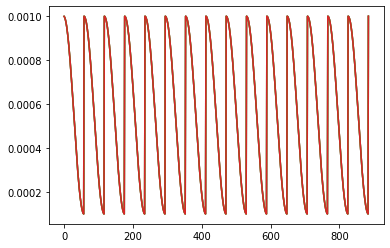

In [16]:
modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

## Predict Function

In [17]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=8,
    )
   
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            print('tmp_pred', tmp_pred)
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

## Ensemble for validation

In [18]:
df_valid = df_valid.set_index("BraTS21ID")

Predict: /home/RSNA_MICCAI_Brain_Tumor/models/FLAIR-e8-loss0.716-auc0.623.pth FLAIR (117, 3)


/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 7, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tmp_pred [0.5092922  0.5067425  0.50951165 0.5090675  0.5096297  0.5084007
 0.5091922  0.5098974 ]
tmp_pred [0.52323115 0.50838447 0.5093175  0.50651276 0.5092457  0.52649707
 0.50876033 0.506498  ]
tmp_pred [0.51405674 0.5094469  0.50934297 0.5063783  0.5107217  0.50939256
 0.50752944 0.5078062 ]
tmp_pred [0.5171236  0.5259065  0.5103826  0.5138859  0.5095069  0.50932723
 0.5095227  0.51249653]
tmp_pred [0.50800145 0.5062631  0.50945157 0.50946015 0.51649094 0.5250601
 0.50904095 0.5057214 ]
tmp_pred [0.5102485  0.51052094 0.50631726 0.52249    0.5094456  0.51218987
 0.5054665  0.5092802 ]
tmp_pred [0.50579524 0.5096071  0.5075195  0.50951314 0.5168475  0.5090184
 0.50742775 0.50702375]
tmp_pred [0.5112423  0.5213739  0.5096964  0.50961226 0.50828695 0.5230575
 0.5086485  0.5079027 ]
tmp_pred [0.5076799  0.5198555  0.5082749  0.50821143 0.51345336 0.5039991
 0.5052454  0.50953525]
tmp_pred [0.5093812 0.5104857 0.5195993 0.5099816 0.5089545 0.5095392 0.5289198
 0.5038551]
tmp_pred [0.5

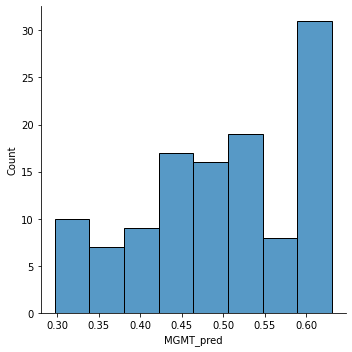

In [19]:
df_valid["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid["MGMT_pred"] += pred["MGMT_value"]
df_valid["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_valid["MGMT_pred"])

## Export to Kaggle

In [20]:
!rm -rf {cfg.models_path/cfg.model_name}

In [21]:
import shutil

if not Path(cfg.models_path/cfg.model_name).exists():
    os.mkdir(cfg.models_path/cfg.model_name)
for m in modelfiles:
    shutil.copy(m, cfg.models_path/cfg.model_name)
    
shutil.make_archive(cfg.models_path/cfg.model_name, 'zip', cfg.models_path/cfg.model_name)

'/home/RSNA_MICCAI_Brain_Tumor/models/efficientnet3d-0.zip'

In [22]:
!du -h {cfg.models_path/cfg.model_name}

252M	/home/RSNA_MICCAI_Brain_Tumor/models/efficientnet3d-0


In [23]:
!rm -rf {cfg.models_path}/*.pth
!rm -rf {cfg.models_path/cfg.model_name}/*.pth

In [24]:
!mv {cfg.models_path/cfg.model_name}.zip {cfg.models_path/cfg.model_name}

In [25]:
!kaggle datasets init -p {cfg.models_path/cfg.model_name}

Data package template written to: /home/RSNA_MICCAI_Brain_Tumor/models/efficientnet3d-0/dataset-metadata.json


In [26]:
dataset_json_path = Path(cfg.models_path/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [27]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'rsna-{cfg.model_name}').replace('INSERT_SLUG_HERE', f'rsna-{cfg.model_name}')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

{
  "title": "rsna-efficientnet3d-0",
  "id": "gilfernandes/rsna-efficientnet3d-0",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}


In [28]:
# !kaggle datasets create -p {cfg.models_path/cfg.model_name}

In [29]:
!kaggle datasets version -p {cfg.models_path/cfg.model_name} -m "Improved data set" -d

Starting upload for file efficientnet3d-0.zip
100%|████████████████████████████████████████| 218M/218M [00:29<00:00, 7.85MB/s]
Upload successful: efficientnet3d-0.zip (218MB)
Dataset version is being created. Please check progress at /api/v1/datasets/status/gilfernandes/rsna-efficientnet3d-0
